<h1  style="color:#1f77b4; font-size:40px"> Object Detection Using Faster-RCNN </h1>

## Demo Using SAS Deep Learning DLPy

In [18]:
from swat import *
import swat as sw
from pprint import pprint
%matplotlib inline
import matplotlib
import sys

from dlpy.network import *
from dlpy.layers import *
from dlpy.model import *
from dlpy.images import ImageTable
from dlpy.sequential import Sequential
from dlpy.utils import display_object_detections, plot_anchors

<h1  style="color:#1f77b4"> Connect to CAS Server and Load Action Sets </h1>

In [19]:
#connect to CAS server and load action sets
s = CAS(host_name, port)

<h1  style="color:#1f77b4"> Build the Model Architecture </h1>

 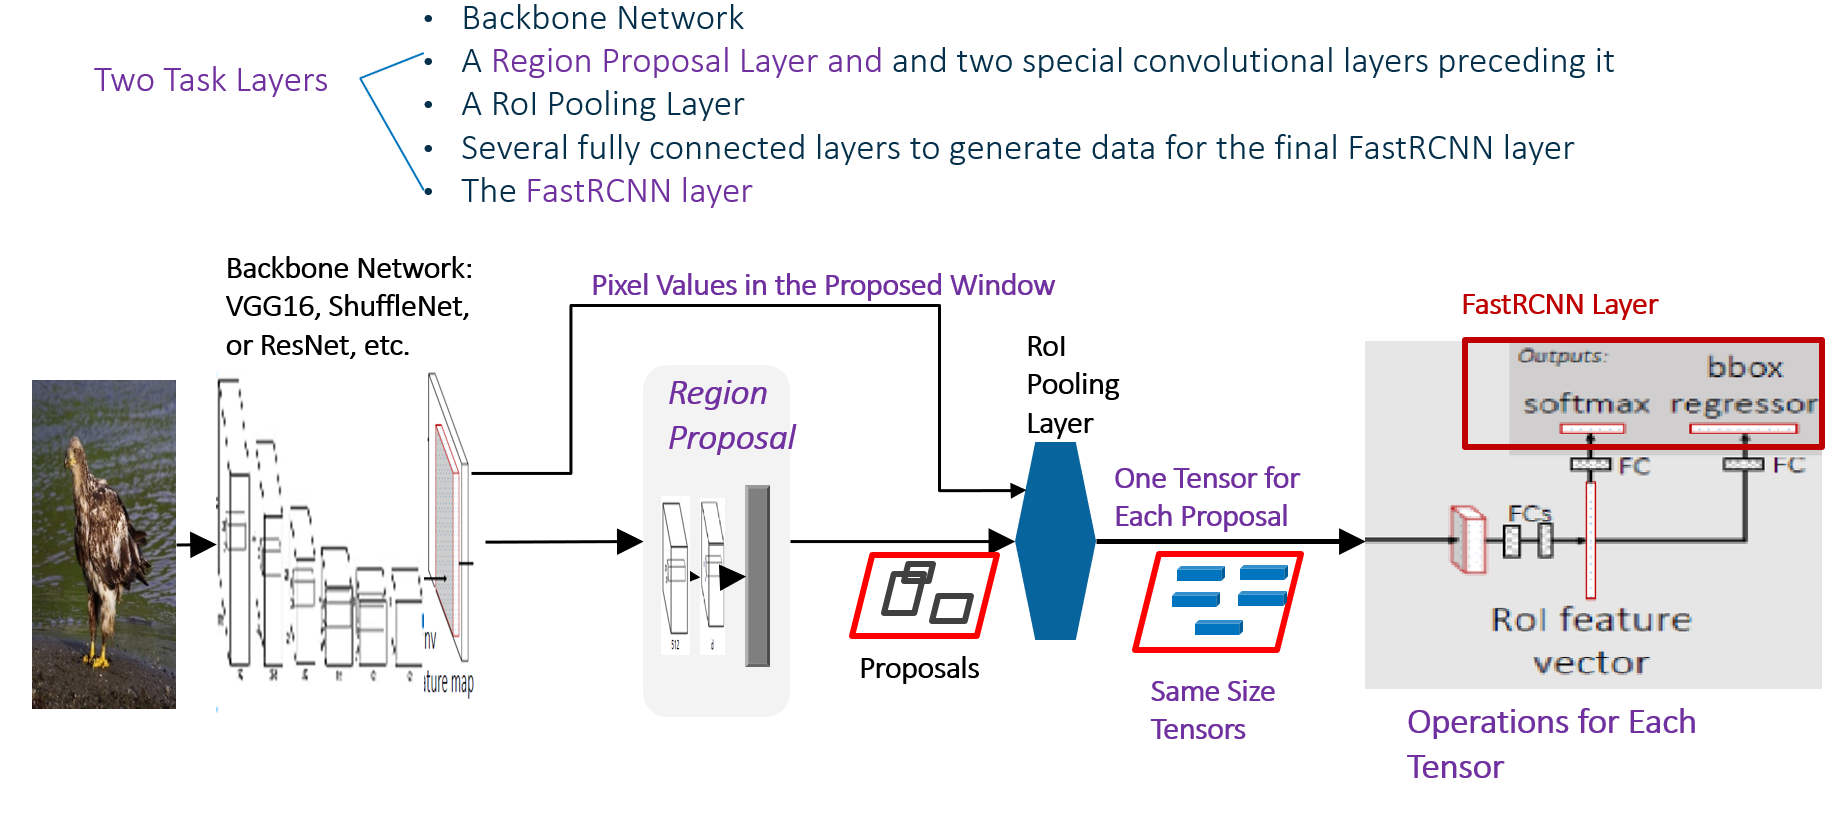

In [20]:
from dlpy.applications import Faster_RCNN

In [21]:
# Add the backbone network
imH=496
imW=1000

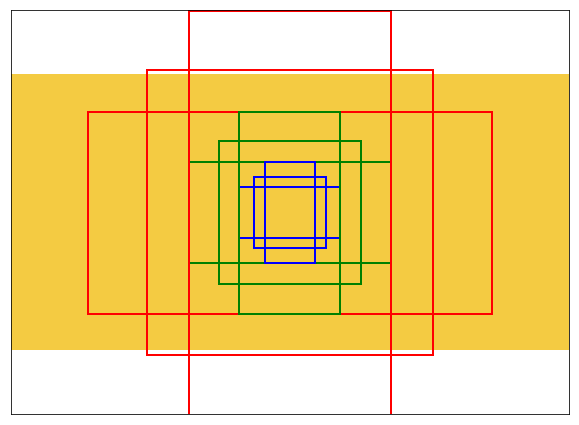

In [22]:
base_anchor_size = 16
anchor_scale = [8, 16, 32]
anchor_ratio = [0.5, 1, 2]
plot_anchors(base_anchor_size=base_anchor_size, 
             anchor_scale=anchor_scale, 
             fig_size=(10, 60),
             anchor_ratio=anchor_ratio, 
             image_size = (imH, imW))

In [23]:
model = Faster_RCNN(s, coord_type='yolo')

NOTE: Model compiled successfully.


In [24]:
model.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,0,data,input,,,None,"(496, 1000, 3)","(0, 0)"
1,1,conv1_1,convo,"(3, 3)","(1, 1)",Relu,"(496, 1000, 64)","(1728, 64)"
2,2,conv1_2,convo,"(3, 3)","(1, 1)",Relu,"(496, 1000, 64)","(36864, 64)"
3,3,pool1,pool,"(2, 2)","(2, 2)",Max,"(248, 500, 64)","(0, 0)"
4,4,conv2_1,convo,"(3, 3)","(1, 1)",Relu,"(248, 500, 128)","(73728, 128)"
5,5,conv2_2,convo,"(3, 3)","(1, 1)",Relu,"(248, 500, 128)","(147456, 128)"
6,6,Pooling_6,pool,"(2, 2)","(2, 2)",Max,"(124, 250, 128)","(0, 0)"
7,7,conv3_1,convo,"(3, 3)","(1, 1)",Relu,"(124, 250, 256)","(294912, 256)"
8,8,conv3_2,convo,"(3, 3)","(1, 1)",Relu,"(124, 250, 256)","(589824, 256)"
9,9,conv3_3,convo,"(3, 3)","(1, 1)",Relu,"(124, 250, 256)","(589824, 256)"


<h1  style="color:#1f77b4"> Load the Data Set </h1>

In [25]:
# define caslib for data
modelPath='/dept/linux/dlpy'
s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'}, 
                  name='rcnn',
                  path=modelPath,
                  subdirectories=True)

#Load the training data set
coordType = 2;
maxObjs = 10;

# we are subsampling the data here
whereStr = "_nObjects_>0 and imgNo < 100"

s.table.loadtable(casout={'name':'trainSet', 'replace':True, 'blocksize':350},
                  caslib='rcnn',
                  path='rcnn_trainSetJoined_Yolo_496_fromRSZ.sashdat', 
                  where=whereStr)
trainSetTbl = s.CASTable('trainSet')
len(trainSetTbl)

NOTE: Cloud Analytic Services added the caslib 'rcnn'.
NOTE: Cloud Analytic Services made the file rcnn_trainSetJoined_Yolo_496_fromRSZ.sashdat available as table TRAINSET in caslib CASUSER(ethem-kinginthenorth).


54

In [26]:
#Load the test data set
coordType = 2;
maxObjs = 10;

whereStr = "_nObjects_>0 and imgNo > 900"

s.table.loadtable(casout={'name':'testSet', 'replace':True, 'blocksize':350},
                  caslib='rcnn',
                  path='rcnn_trainSetJoined_Yolo_496_fromRSZ.sashdat', 
                  where=whereStr,
                  vars=['_image_'])
testSetTbl = s.CASTable('testSet')
len(testSetTbl)

NOTE: Cloud Analytic Services made the file rcnn_trainSetJoined_Yolo_496_fromRSZ.sashdat available as table TESTSET in caslib CASUSER(ethem-kinginthenorth).


49

<h1  style="color:#1f77b4">  Visualize the Data Set and Label Graphically </h1>

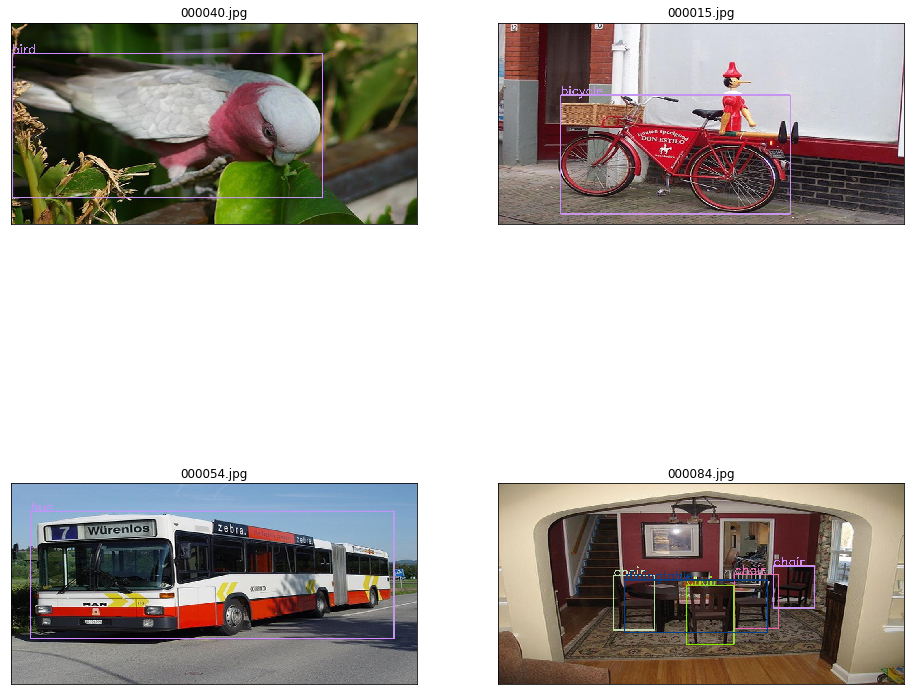

In [28]:
display_object_detections(s, trainSetTbl, 'yolo', n_col=2, num_plot=4)

### Load the Pre-Trained Weights </h1>

In [29]:
#Load the pre-trained weights
s.table.loadtable(casout={'name':'VGG16_RCNN_Weights_YOLOWithLabelAttr1','replace':True}, 
                  caslib='rcnn',
                  path="VGG16_RCNN_Weights_YOLOWithLabelAttr.sashdat")
s.table.loadtable(casout={'replace':True}, 
                  caslib='rcnn',
                  path='VGG16_RCNN_Weights_AttrOfYoloWithFullLabel.sashdat')
s.table.attribute(name='VGG16_RCNN_Weights_YOLOWithLabelAttr1',
                  table='VGG16_RCNN_Weights_AttrOfYoloWithFullLabel')
model.set_weights('VGG16_RCNN_Weights_YOLOWithLabelAttr1')

NOTE: Cloud Analytic Services made the file VGG16_RCNN_Weights_YOLOWithLabelAttr.sashdat available as table VGG16_RCNN_WEIGHTS_YOLOWITHLABELATTR1 in caslib CASUSER(ethem-kinginthenorth).
NOTE: Cloud Analytic Services made the file VGG16_RCNN_Weights_AttrOfYoloWithFullLabel.sashdat available as table VGG16_RCNN_WEIGHTS_ATTROFYOLOWITHFULLLABEL in caslib CASUSER(ethem-kinginthenorth).
NOTE: Model weights attached successfully!


### Define Target Columns </h1>

In [30]:
#Define some variables
maxDet = 22;
if coordType == 1:
    coordColumnStrList = ["xmin", "ymin", "xmax", "ymax"]      
else:    
    coordColumnStrList = ["x", "y", "width", "height"]
 
 
targets = ['_nObjects_'];
for i in range(0,maxDet):
    targets.append('_Object%d_'%i)
    for sp in coordColumnStrList:
        targets.append ('_Object%d_%s'%(i, sp))

inputVars = ['_image_']

<h1  style="color:#1f77b4">  Training </h1>

In [31]:
gpus = Gpu(devices=[0])
optimizer=Optimizer(mini_batch_size=2, 
                    algorithm=MomentumSolver(learning_rate=0.0001),
                    log_level=5, 
                    max_epochs=1, 
                    reg_l2=0.0001)

data_specs = [DataSpec(type_='IMAGE', layer='data', data=inputVars), 
              DataSpec(type_='OBJECTDETECTION', layer='rois', data=targets)]

model.fit(data=trainSetTbl, 
          optimizer=optimizer, 
          n_threads=4,
          data_specs=data_specs, 
          gpu=gpus, 
          record_seed=13309)

NOTE: Training based on existing weights.
NOTE: The forward, fit and loss error, and backward operations of the layer 'rois' are performed on CPU.
NOTE: The forward operation of the layer 'roi_pooling' is performed on CPU.
NOTE: The backward operation of the layer 'roi_pooling' is performed on CPU.
NOTE: The forward, fit and loss error, and backward operations of the layer 'fastrcnn' are performed on CPU.
NOTE: Using dlgrd008.unx.sas.com: 1 out of 2 available GPU devices.
NOTE: dlgrd008.unx.sas.com: GPU 0 processes up to 8 records at a time.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 137078239.
NOTE:  The approximate memory cost is 12779.00 MB.
NOTE:  Loading weights cost       2.03 (s).
NOTE:  Initializing each layer cost      12.13 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 2.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 8.
NOTE:  Numb

,Descr,Value
0,Model Name,faster_rcnn
1,Model Type,Convolutional Neural Network
2,Number of Layers,27
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,15
6,Number of Pooling Layers,4
7,Number of Fully Connected Layers,4
8,Number of Region Proposal Layers,1
9,Number of ROI Pooling Layers,1


In [32]:
model.predict(data=testSetTbl, 
              n_threads=1, 
              gpu=gpus, 
              log_level=5, 
              mini_batch_buf_size=2)

NOTE: The forward operation of the layer 'rois' is performed on CPU.
NOTE: The fit and loss error calculation of the layer 'rois' is performed on CPU.
NOTE: The forward operation of the layer 'roi_pooling' is performed on CPU.
NOTE: The forward operation of the layer 'fastrcnn' is performed on CPU.
NOTE: The fit and loss error calculation of the layer 'fastrcnn' is performed on CPU.
NOTE: Using dlgrd008.unx.sas.com: 1 out of 2 available GPU devices.
NOTE: dlgrd008.unx.sas.com: GPU 0 processes up to 10 records at a time.
NOTE:  Loading weights cost       3.14 (s).
NOTE:  Initializing each layer cost      11.31 (s).
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0    10        0                0          0     5.24
NOTE:          LayerID  LayerName  StatsName  Value
NOTE:               20       rois       Loss        0
NOTE:               20       rois    LocLoss        0
NOTE:               20       rois  ClassLoss        0
NOTE:               

[ScoreInfo]

                                       Descr         Value
 0               Number of Observations Read            49
 1               Number of Observations Used             0
 2  Average IOU in Detection (fastrcnn,  26)             0
 3                                Loss Error             .

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(ethem-kinginthenorth)  Valid_Res_pODug3    49      302   
 
                                             casTable  
 0  CASTable('Valid_Res_pODug3', caslib='CASUSER(e...  

+ Elapsed: 30.1s, user: 24.9s, sys: 5.69s, mem: 8.59e+03mb

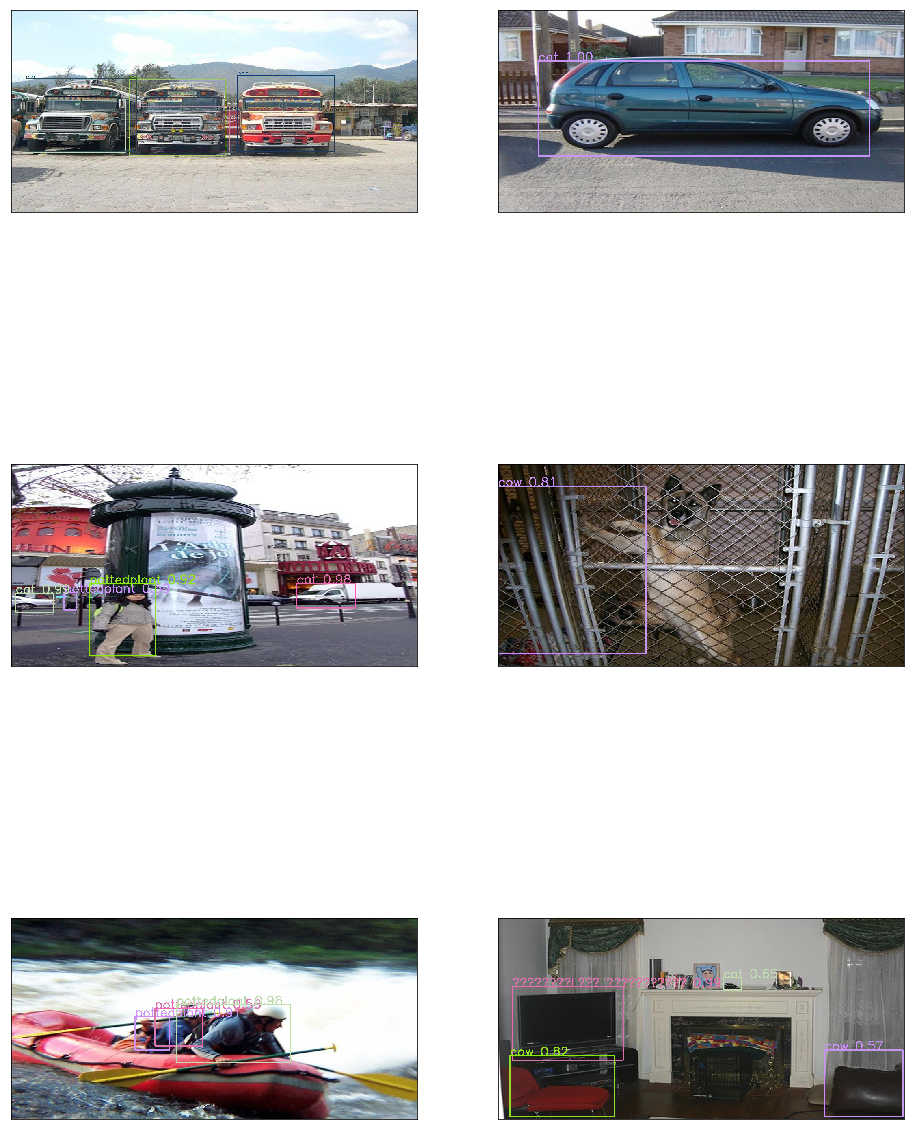

In [36]:
display_object_detections(s,  model.valid_res_tbl, 'yolo', num_plot=6, n_col=2)

In [37]:
s.endsession()

+ Elapsed: 0.000147s, user: 0.000222s, mem: 0.199mb